# HKL calculation, compared to SPEC results

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import gi
gi.require_version('Hkl', '5.0')
from hkl.calc import CalcE6C

## Load the desired HKL trajectory

In [2]:
hkls = pd.read_csv('hkl_data/hkl.txt', delim_whitespace=True)
hkls.keys()

Index(['h', 'k', 'l'], dtype='object')

## Get the motor positions that SPEC calculated

In [3]:
# The motor positions according to SPEC
spec_motors = pd.read_csv('hkl_data/motors.txt', delim_whitespace=True)
spec_motors.keys()

Index(['Delta', 'Theta', 'Chi', 'Phi', 'Mu', 'Gamma'], dtype='object')

## Plot the trajectory of the physical motors

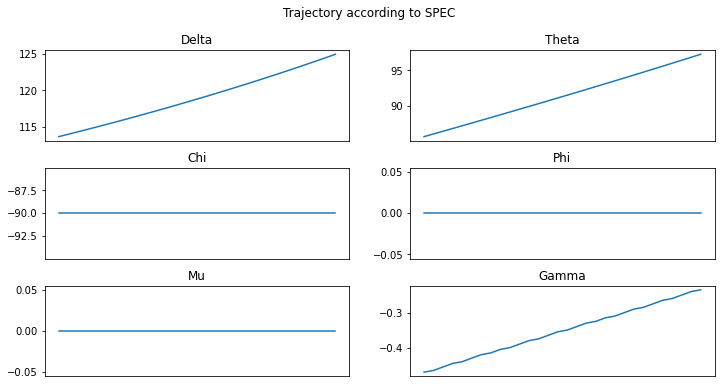

In [4]:
fig, axes = plt.subplots(3, 2, figsize=(12, 6),
                         subplot_kw={'xticks': []})
fig.subplots_adjust(hspace=0.3, wspace=0.2)

plt.suptitle('Trajectory according to SPEC')
for ax, key in zip(axes.flat, spec_motors.keys()):
    ax.plot(spec_motors.index, spec_motors[key], label=key)
    ax.set_title(key)
plt.show()

## Plot the desired HKL trajectory

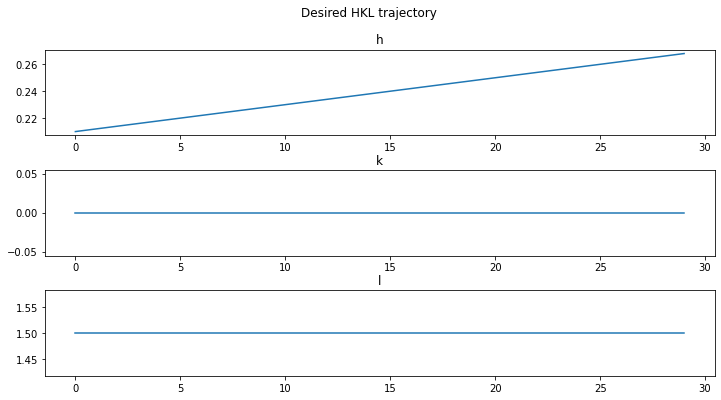

In [5]:
fig, axes = plt.subplots(3, 1, figsize=(12, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.2)

plt.suptitle('Desired HKL trajectory')
axes[0].plot(hkls.h)
axes[0].set_title('h')
axes[1].plot(hkls.k)
axes[1].set_title('k')
axes[2].plot(hkls.l)
axes[2].set_title('l')
plt.show()

## Initialize a calculation engine

In [6]:
calc = CalcE6C(engine='hkl')
calc.wavelength = 1.33e1  # not nm, angstroms
print('mode is', calc.engine.mode)
print('physical axes', calc.physical_axes)
print('pseudo axes', calc.pseudo_axes)
print('omega parameter is', calc['omega'])

mode is bissector_vertical
physical axes OrderedDict([('mu', 0.0), ('omega', 0.0), ('chi', 0.0), ('phi', 0.0), ('gamma', 0.0), ('delta', 0.0)])
pseudo axes OrderedDict([('h', 0.0), ('k', 0.0), ('l', 0.0)])
omega parameter is CalcParameter(name='omega', limits=(-180.0, 180.0), value=0.0, fit=True, inverted=False, units='Degree')


## Set some constraints on the physical motors

In [7]:
# First, show the default constraints
for axis in calc.physical_axis_names:
    print(calc[axis])

if False:
    phi = calc['phi']
    phi.limits = (0, 0)
    phi.value = 0
    phi.fit = False

    chi = calc['chi']
    chi.limits = (-90, -90)
    chi.value = -90
    chi.fit = False

    mu = calc['mu']
    mu.limits = (0, 0)
    mu.value = 0
    mu.fit = False

print("updated constraints:")
print(calc['phi'])
print(calc['chi'])
print(calc['mu'])

CalcParameter(name='mu', limits=(-180.0, 180.0), value=0.0, fit=True, inverted=False, units='Degree')
CalcParameter(name='omega', limits=(-180.0, 180.0), value=0.0, fit=True, inverted=False, units='Degree')
CalcParameter(name='chi', limits=(-180.0, 180.0), value=0.0, fit=True, inverted=False, units='Degree')
CalcParameter(name='phi', limits=(-180.0, 180.0), value=0.0, fit=True, inverted=False, units='Degree')
CalcParameter(name='gamma', limits=(-180.0, 180.0), value=0.0, fit=True, inverted=False, units='Degree')
CalcParameter(name='delta', limits=(-180.0, 180.0), value=0.0, fit=True, inverted=False, units='Degree')
updated constraints:
CalcParameter(name='phi', limits=(-180.0, 180.0), value=0.0, fit=True, inverted=False, units='Degree')
CalcParameter(name='chi', limits=(-180.0, 180.0), value=0.0, fit=True, inverted=False, units='Degree')
CalcParameter(name='mu', limits=(-180.0, 180.0), value=0.0, fit=True, inverted=False, units='Degree')


# Work with a sample

In [8]:
# from ophyd.hkl.sample import HklSample
# new_sample supports kwargs (see `help(HklSample)`)
from hkl.util import Lattice
lattice = Lattice(a=3.78, b=3.78, c=13.28, alpha=90, beta=90, gamma=90)
sample = calc.new_sample('sample0', lattice=lattice)

## Primary reflection

In [9]:
r1 = sample.add_reflection(
    0, 0, 2,
    position=calc.Position(
        mu=0.0, omega=71.04, chi=-90.0, phi=0.0, gamma=-1.65, delta=136.7))

## Secondary reflection

In [10]:
r2 = sample.add_reflection(
    1, 0, 1,
    position=calc.Position(
        mu=0.0, omega=158.22, chi=-90.0, phi=0.0, gamma=1.7, delta=164.94))

## Calculate the UB matrix

In [11]:
sample.compute_UB(r1, r2)
print(np.array(sample.UB))

spec_ub = [[0.0338309723166807, 1.6616745234937, -0.00732930331262271],
           [1.66007365775423, -0.032591767600211, 0.0221634966739925],
           [0.0773350510852808, -0.0273010739795478, -0.472555187096841]
           ]
print('from spec:\n', np.array(spec_ub))

[[ 1.66011306  0.0298982   0.02223195]
 [ 0.07775045  0.02016382 -0.4725787 ]
 [-0.03081074  1.6618271   0.00533407]]
from spec:
 [[ 0.03383097  1.66167452 -0.0073293 ]
 [ 1.66007366 -0.03259177  0.0221635 ]
 [ 0.07733505 -0.02730107 -0.47255519]]


## Check one (_hkl_) reflection from the test data

In [72]:
# h k l
# 0.21 0 1.5
#
#     Delta     Theta       Chi       Phi        Mu     Gamma
# 113.6647   85.7031  -90.0000    0.0000    0.0000   -0.4700

calc.physical_positions = calc.Position(
    mu=0.0, omega=85.7031, chi=-90.0, phi=0.0, gamma=-0.47, delta=113.6647)
print("physical positions=", calc.physical_positions)
print('pseudo should be (0.21, 0, 1.5)=', calc.pseudo_axes)


physical positions= PosCalcE6C(mu=0.0, omega=85.7031, chi=-90.0, phi=0.0, gamma=-0.47, delta=113.6647)
pseudo should be (0.21, 0, 1.5)= OrderedDict([('h', 0.20994021606732546), ('k', 1.336972588470526e-05), ('l', 1.500103655211857)])


## Compute (_hkl_) from this position

In [80]:
# FIXME: So far, only works when previous constraints are removed.  Wrong mode?
for axis in "chi mu phi".split():
    calc[axis].limits = (-180, 180)
    calc[axis].fit = True
    calc[axis].value = 0.0

# FIXME: pick mode
# see: https://repo.or.cz/hkl.git/blob/HEAD:/Documentation/sphinx/source/diffractometers/e6c.rst
# constant_omega_vertical: close but cannot fix phi=0
# constant_mu_horizontal: close but cannot fix phi=0
# constant_phi_vertical has right values but omega, chi, delta have wrong sign
# psi_constant_vertical:  close but cannot fix phi=0, needs second psi reflection
calc.engine.mode = "constant_omega_vertical"

print("possible modes", calc.engine.modes)
print("chosen modes", calc.engine.mode)
print("wavelength, A", calc.wavelength)
print("Constraints:")
for axis in calc.physical_axis_names:
    print(calc[axis])
print("Solution(s) for (0.21 0 1.5):\n", calc.forward((0.21, 0, 1.5)))

possible modes ['bissector_vertical', 'constant_omega_vertical', 'constant_chi_vertical', 'constant_phi_vertical', 'lifting_detector_phi', 'lifting_detector_omega', 'lifting_detector_mu', 'double_diffraction_vertical', 'bissector_horizontal', 'double_diffraction_horizontal', 'psi_constant_vertical', 'psi_constant_horizontal', 'constant_mu_horizontal']
chosen modes constant_omega_vertical
wavelength, A 13.3
Constraints:
CalcParameter(name='mu', limits=(-180.0, 180.0), value=0.0, fit=True, inverted=False, units='Degree')
CalcParameter(name='omega', limits=(-180.0, 180.0), value=85.7031, fit=True, inverted=False, units='Degree')
CalcParameter(name='chi', limits=(-180.0, 180.0), value=0.0, fit=True, inverted=False, units='Degree')
CalcParameter(name='phi', limits=(-180.0, 180.0), value=0.0, fit=True, inverted=False, units='Degree')
CalcParameter(name='gamma', limits=(-180.0, 180.0), value=-0.47, fit=True, inverted=False, units='Degree')
CalcParameter(name='delta', limits=(-180.0, 180.0), v

## Calculate the trajectory

In [14]:
for seq, (h, k, l) in hkls.iterrows():
    print('-- hkl {} --'.format((h, k, l)))
    print('Solutions:')
    for sol in calc.forward((h, k, l)):
        print('\t{}'.format(sol))
        
    break

-- hkl (0.21, 0.0, 1.5) --
Solutions:
	PosCalcE6C(mu=0.0, omega=-56.832335627765005, chi=61.23349385814405, phi=-90.22910278033105, gamma=-0.47, delta=-113.66467125553001)
